# 2. Feature Engineering

In [1]:
import pandas as pd

from paths import PROCESSED_CSV_FILE, ENGINEERED_CSV_FILE, FEATURE_ENG_DIR
from ml_tools.data_exploration import info
info(full_info=False)

Available functions for data exploration:
get_features_targets, summarize_dataframe, show_null_columns, drop_columns_with_missing_data, clip_outliers_single, clip_outliers_multi, plot_correlation_heatmap, check_value_distributions, merge_dataframes, split_continuous_and_binary, save_dataframe, compute_vif, drop_vif_based


In [2]:
from ml_tools.data_exploration import get_features_targets, summarize_dataframe, show_null_columns, drop_columns_with_missing_data, clip_outliers_multi, plot_correlation_heatmap, check_value_distributions, merge_dataframes, split_continuous_and_binary, save_dataframe

## 1. Get datasets with Splits (Features, Target)

In [3]:
TARGETS = ["capacity", "capacity retention", "first coulombic efficiency"]
df, df_targets, df_features = get_features_targets(df_path=PROCESSED_CSV_FILE, targets=TARGETS)

Original shape: (1220, 126)
Targets shape: (1220, 3)
Features shape: (1220, 123)


## 2. Explore Data

In [4]:
summarize_dataframe(df_features)

                 Data Type  Non-Null Count  Unique Values  Missing %  mean  \
coating material   float64             640              2      47.54  0.71   
dopant_Li            int64            1220              2       0.00  0.00   
dopant_B             int64            1220              2       0.00  0.02   
dopant_C             int64            1220              2       0.00  0.00   
dopant_N             int64            1220              2       0.00  0.03   
...                    ...             ...            ...        ...   ...   
ratio_Se           float64            1220              3       0.00  0.01   
ratio_La           float64            1220             10       0.00  0.02   
ratio_Ce           float64            1220              2       0.00  0.00   
ratio_Gd           float64            1220              4       0.00  0.00   
ratio_Ta           float64            1220             12       0.00  0.01   

                   std  min  25%  50%  75%   max  
coating mate

,Data Type,Non-Null Count,Unique Values,Missing %,mean,std,min,25%,50%,75%,max
coating material,float64,640,2,47.54,0.71,0.45,0.0,0.0,1.0,1.0,1.00
dopant_Li,int64,1220,2,0.00,0.00,0.06,0.0,0.0,0.0,0.0,1.00
dopant_B,int64,1220,2,0.00,0.02,0.14,0.0,0.0,0.0,0.0,1.00
dopant_C,int64,1220,2,0.00,0.00,0.03,0.0,0.0,0.0,0.0,1.00
dopant_N,int64,1220,2,0.00,0.03,0.17,0.0,0.0,0.0,0.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
ratio_Se,float64,1220,3,0.00,0.01,0.10,0.0,0.0,0.0,0.0,2.00
ratio_La,float64,1220,10,0.00,0.02,0.18,0.0,0.0,0.0,0.0,3.00
ratio_Ce,float64,1220,2,0.00,0.00,0.05,0.0,0.0,0.0,0.0,1.00
ratio_Gd,float64,1220,4,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.03


In [5]:
summarize_dataframe(df_targets)

                           Data Type  Non-Null Count  Unique Values  \
capacity                     float64            1063            643   
capacity retention           float64             974            375   
first coulombic efficiency   float64             702            373   

                            Missing %    mean     std   min    25%     50%  \
capacity                        12.87  219.98  217.33  0.10  183.3  201.68   
capacity retention              20.16   71.31   30.62  1.03   59.7   83.00   
first coulombic efficiency      42.46   83.91   12.30  1.02   81.0   86.00   

                               75%     max  
capacity                    226.30  4850.0  
capacity retention           92.57   100.0  
first coulombic efficiency   89.97   100.0  


,Data Type,Non-Null Count,Unique Values,Missing %,mean,std,min,25%,50%,75%,max
capacity,float64,1063,643,12.87,219.98,217.33,0.10,183.3,201.68,226.30,4850.0
capacity retention,float64,974,375,20.16,71.31,30.62,1.03,59.7,83.00,92.57,100.0
first coulombic efficiency,float64,702,373,42.46,83.91,12.30,1.02,81.0,86.00,89.97,100.0


## 3. Null values

In [6]:
show_null_columns(df_features)

                         Missing Count  Missing %
annealing time 3                  1142      93.61
annealing temperature 3           1141      93.52
precursor temperature             1051      86.15
precursor pH                      1045      85.66
secondary particle size            818      67.05
annealing time 2                   708      58.03
annealing temperature 2            688      56.39
primary particle size              676      55.41
coating material                   580      47.54
electrolyte molarity               517      42.38
polycrystalline                    461      37.79
cycles                             379      31.07
annealing time 1                   342      28.03
annealing temperature 1            320      26.23
solvent_DMC                        115       9.43
solvent_EC                         115       9.43
solvent_VC                         115       9.43
solvent_EMC                        115       9.43
solvent_PC                         115       9.43


In [7]:
show_null_columns(df_targets)

                            Missing Count  Missing %
first coulombic efficiency            518      42.46
capacity retention                    246      20.16
capacity                              157      12.87


Drop columns with too many Null values from the main dataframe

In [8]:
df_lessnulls_features = drop_columns_with_missing_data(df_features, threshold=0.7)
show_null_columns(df_lessnulls_features)

Dropping columns with more than 70% missing data:
['precursor pH', 'precursor temperature', 'annealing temperature 3', 'annealing time 3']
                         Missing Count  Missing %
secondary particle size            818      67.05
annealing time 2                   708      58.03
annealing temperature 2            688      56.39
primary particle size              676      55.41
coating material                   580      47.54
electrolyte molarity               517      42.38
polycrystalline                    461      37.79
cycles                             379      31.07
annealing time 1                   342      28.03
annealing temperature 1            320      26.23
solvent_DMC                        115       9.43
solvent_EC                         115       9.43
solvent_VC                         115       9.43
solvent_EMC                        115       9.43
solvent_PC                         115       9.43
solvent_DEC                        115       9.43
solvent_DME

## 4. Split features: Continuous - Binary

In [9]:
df_lessnulls_cont, df_lessnulls_binary = split_continuous_and_binary(df=df_lessnulls_features)

Continuous columns shape: (1220, 41)
Binary columns shape: (1220, 78)


## 5. Clip values

In [ ]:
# Check columns without saving plots
# check_value_distributions(df=df_lessnulls_cont)

Use maximum and minimum values to clip outliers

In [10]:
features_clip_dict = {"primary particle size": (0.0,30.0),
                      "secondary particle size": (0.0,30.0),
                      "annealing temperature 1": (650.0,1225.0),
                      "annealing temperature 2": (650.0,1225.0),
                      "annealing time 1": (1.0,48.0),
                      "annealing time 2": (1.0,48.0),
                      "average voltage": (1.0,5.0),
                      "electrolyte molarity": (0.1,5.0),
                      "cycles": (5,3500),
                    #   "ratio_Li": (0.0,4.0),
                    #   "ratio_Na": (0.0,4.0),
                    #   "ratio_Mg": (0.0,4.0),
                    #   "ratio_Ti": (0.0,4.0),
                    #   "ratio_Mn": (0.0,4.0),
                    #   "ratio_Fe": (0.0,4.0),
                    #   "ratio_Co": (0.0,4.0),
                    #   "ratio_Ni": (0.0,4.0),
                    #   "ratio_O": (0.0,4.0),
                    #   "ratio_F": (0.0,4.0),
                    #   "ratio_P": (0.0,4.0),
                    #   "ratio_S": (0.0,4.0),
                    #   "ratio_Al": (0.0,4.0),
                    #   "ratio_Si": (0.0,4.0),
                    #   "ratio_Zr": (0.0,4.0),
                    #   "ratio_Nb": (0.0,4.0),
                    #   "ratio_Sn": (0.0,4.0),
                    #   "ratio_C": (0.0,4.0)
                      }

df_lessnulls_clip_cont = clip_outliers_multi(df=df_lessnulls_cont, clip_dict=features_clip_dict,)

## 6. Correlation Heatmap

Continuous features

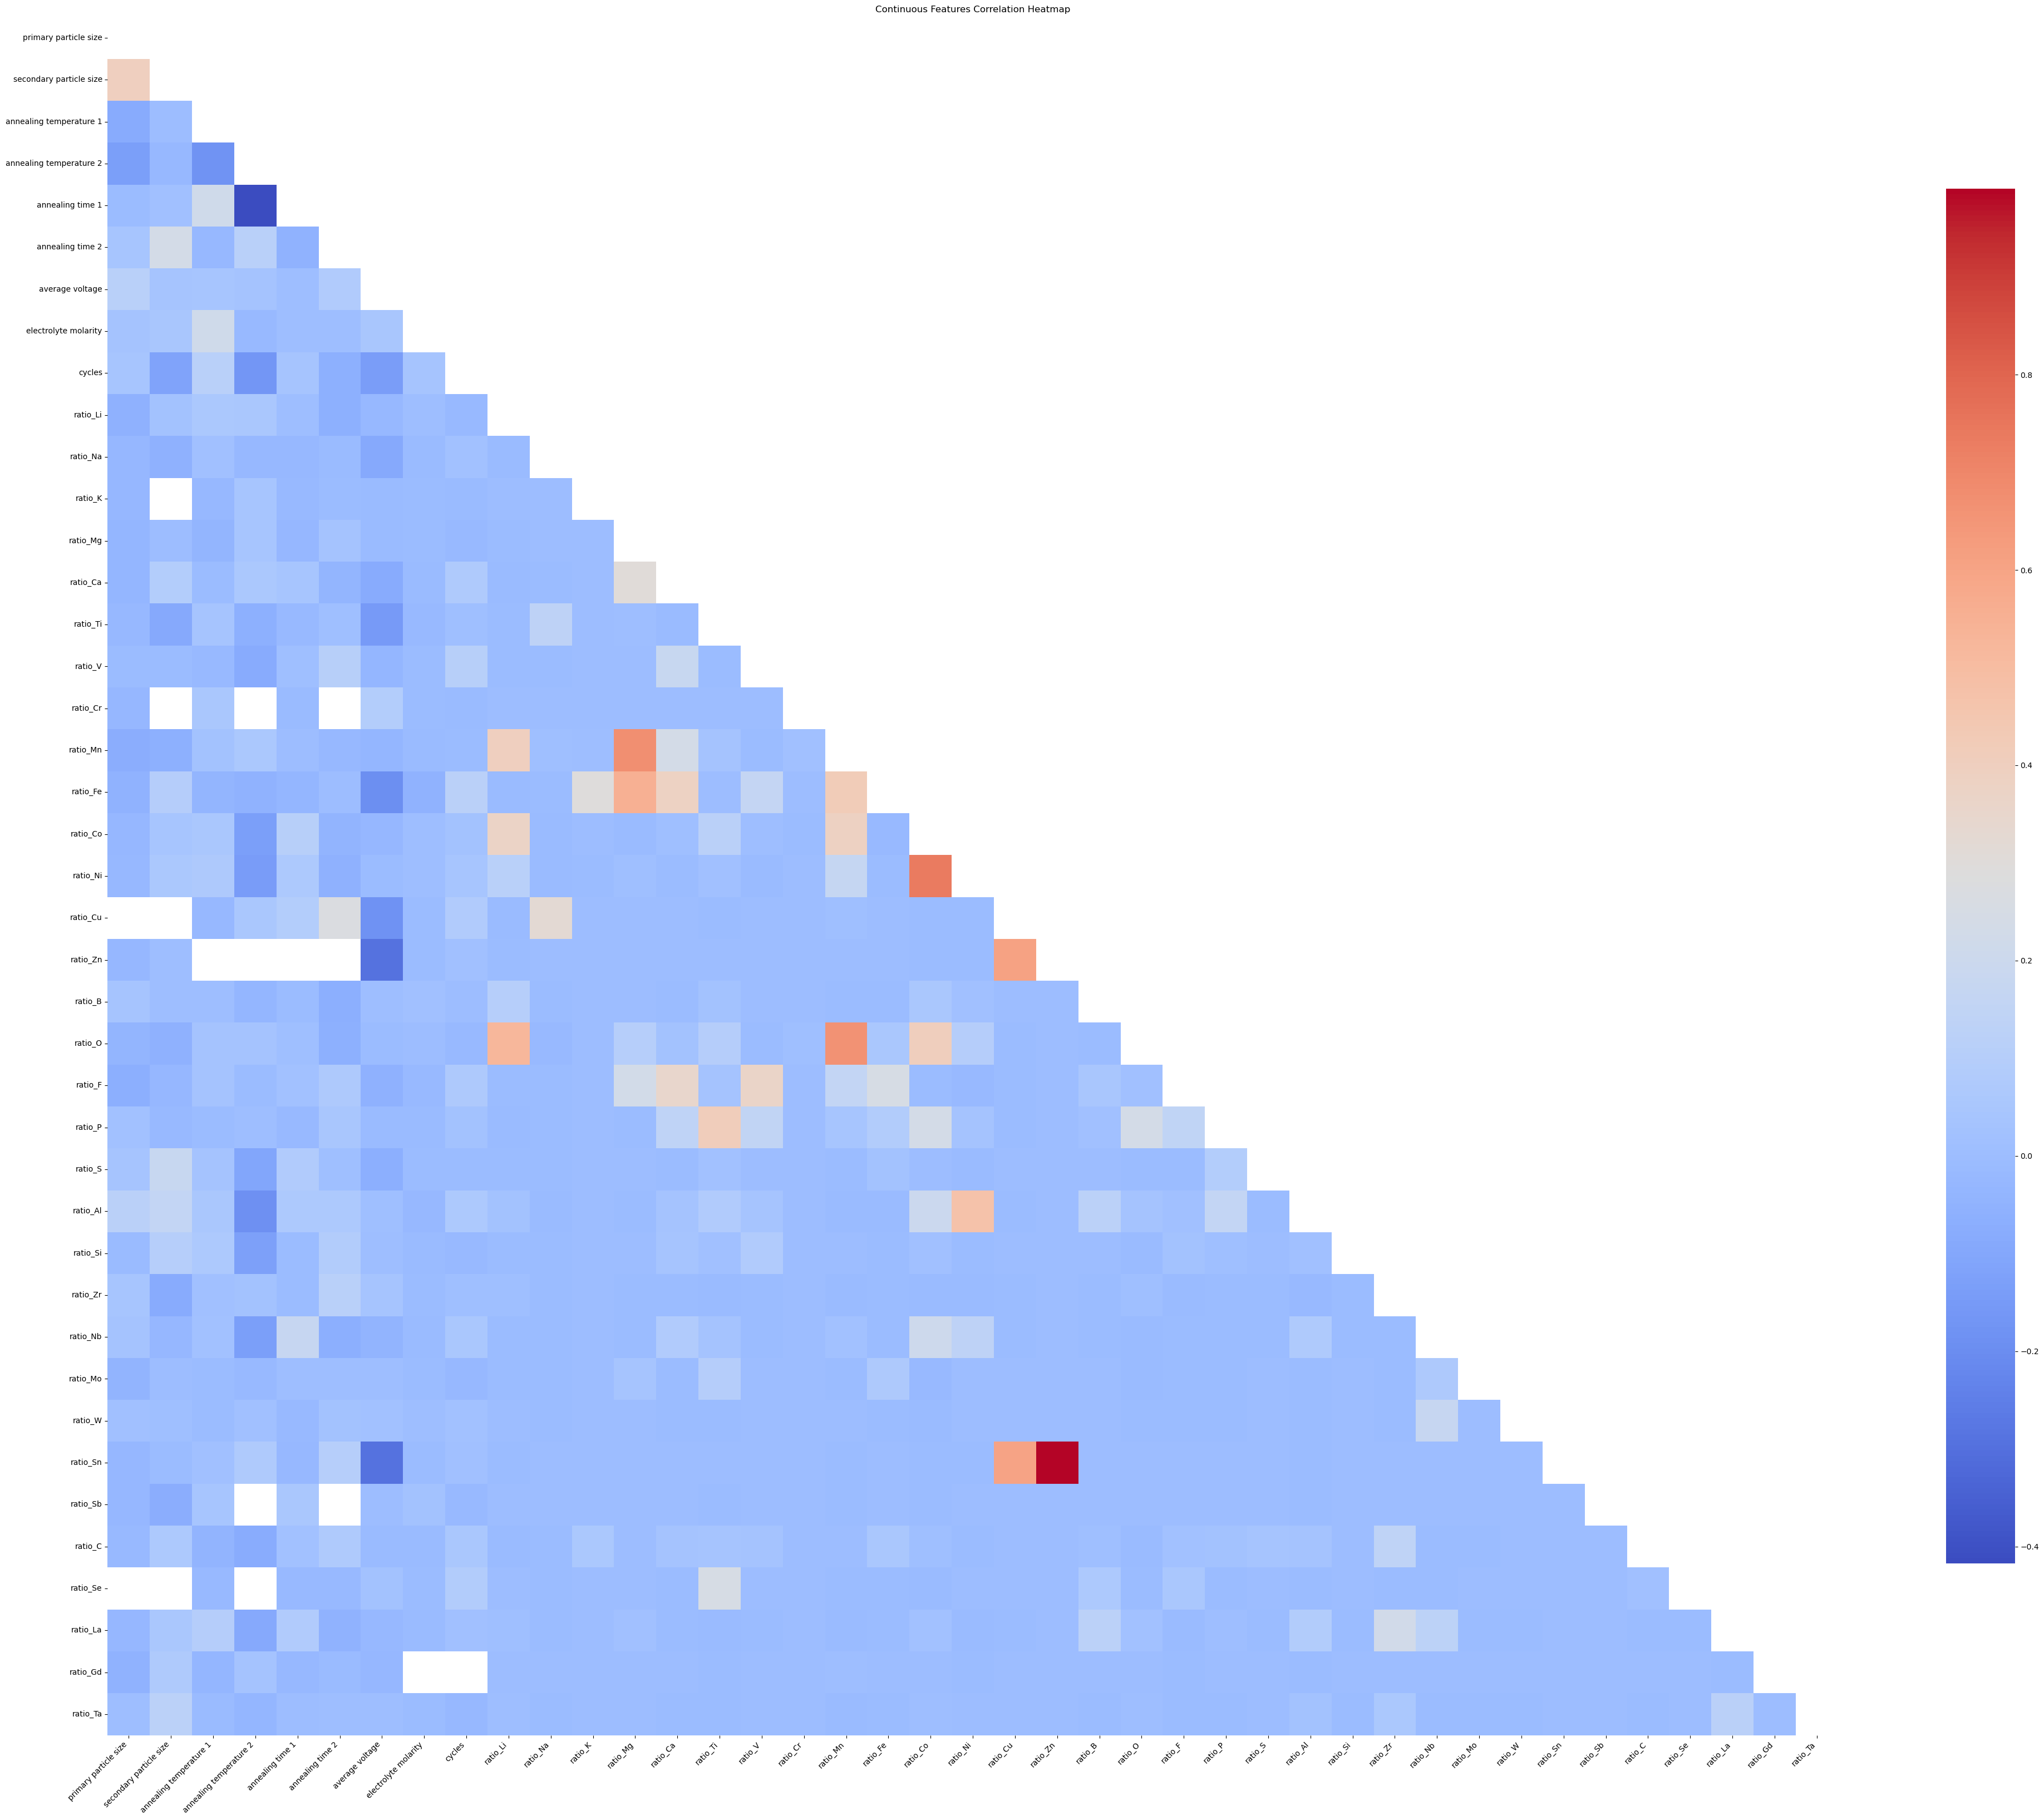

Saved correlation heatmap to: /home/karl/lithium_battery/data/Feature Engineering/Continuous Features Correlation Heatmap.svg


In [11]:
plot_correlation_heatmap(df=df_lessnulls_clip_cont, save_dir=FEATURE_ENG_DIR, plot_title="Continuous Features Correlation Heatmap")

Binary features

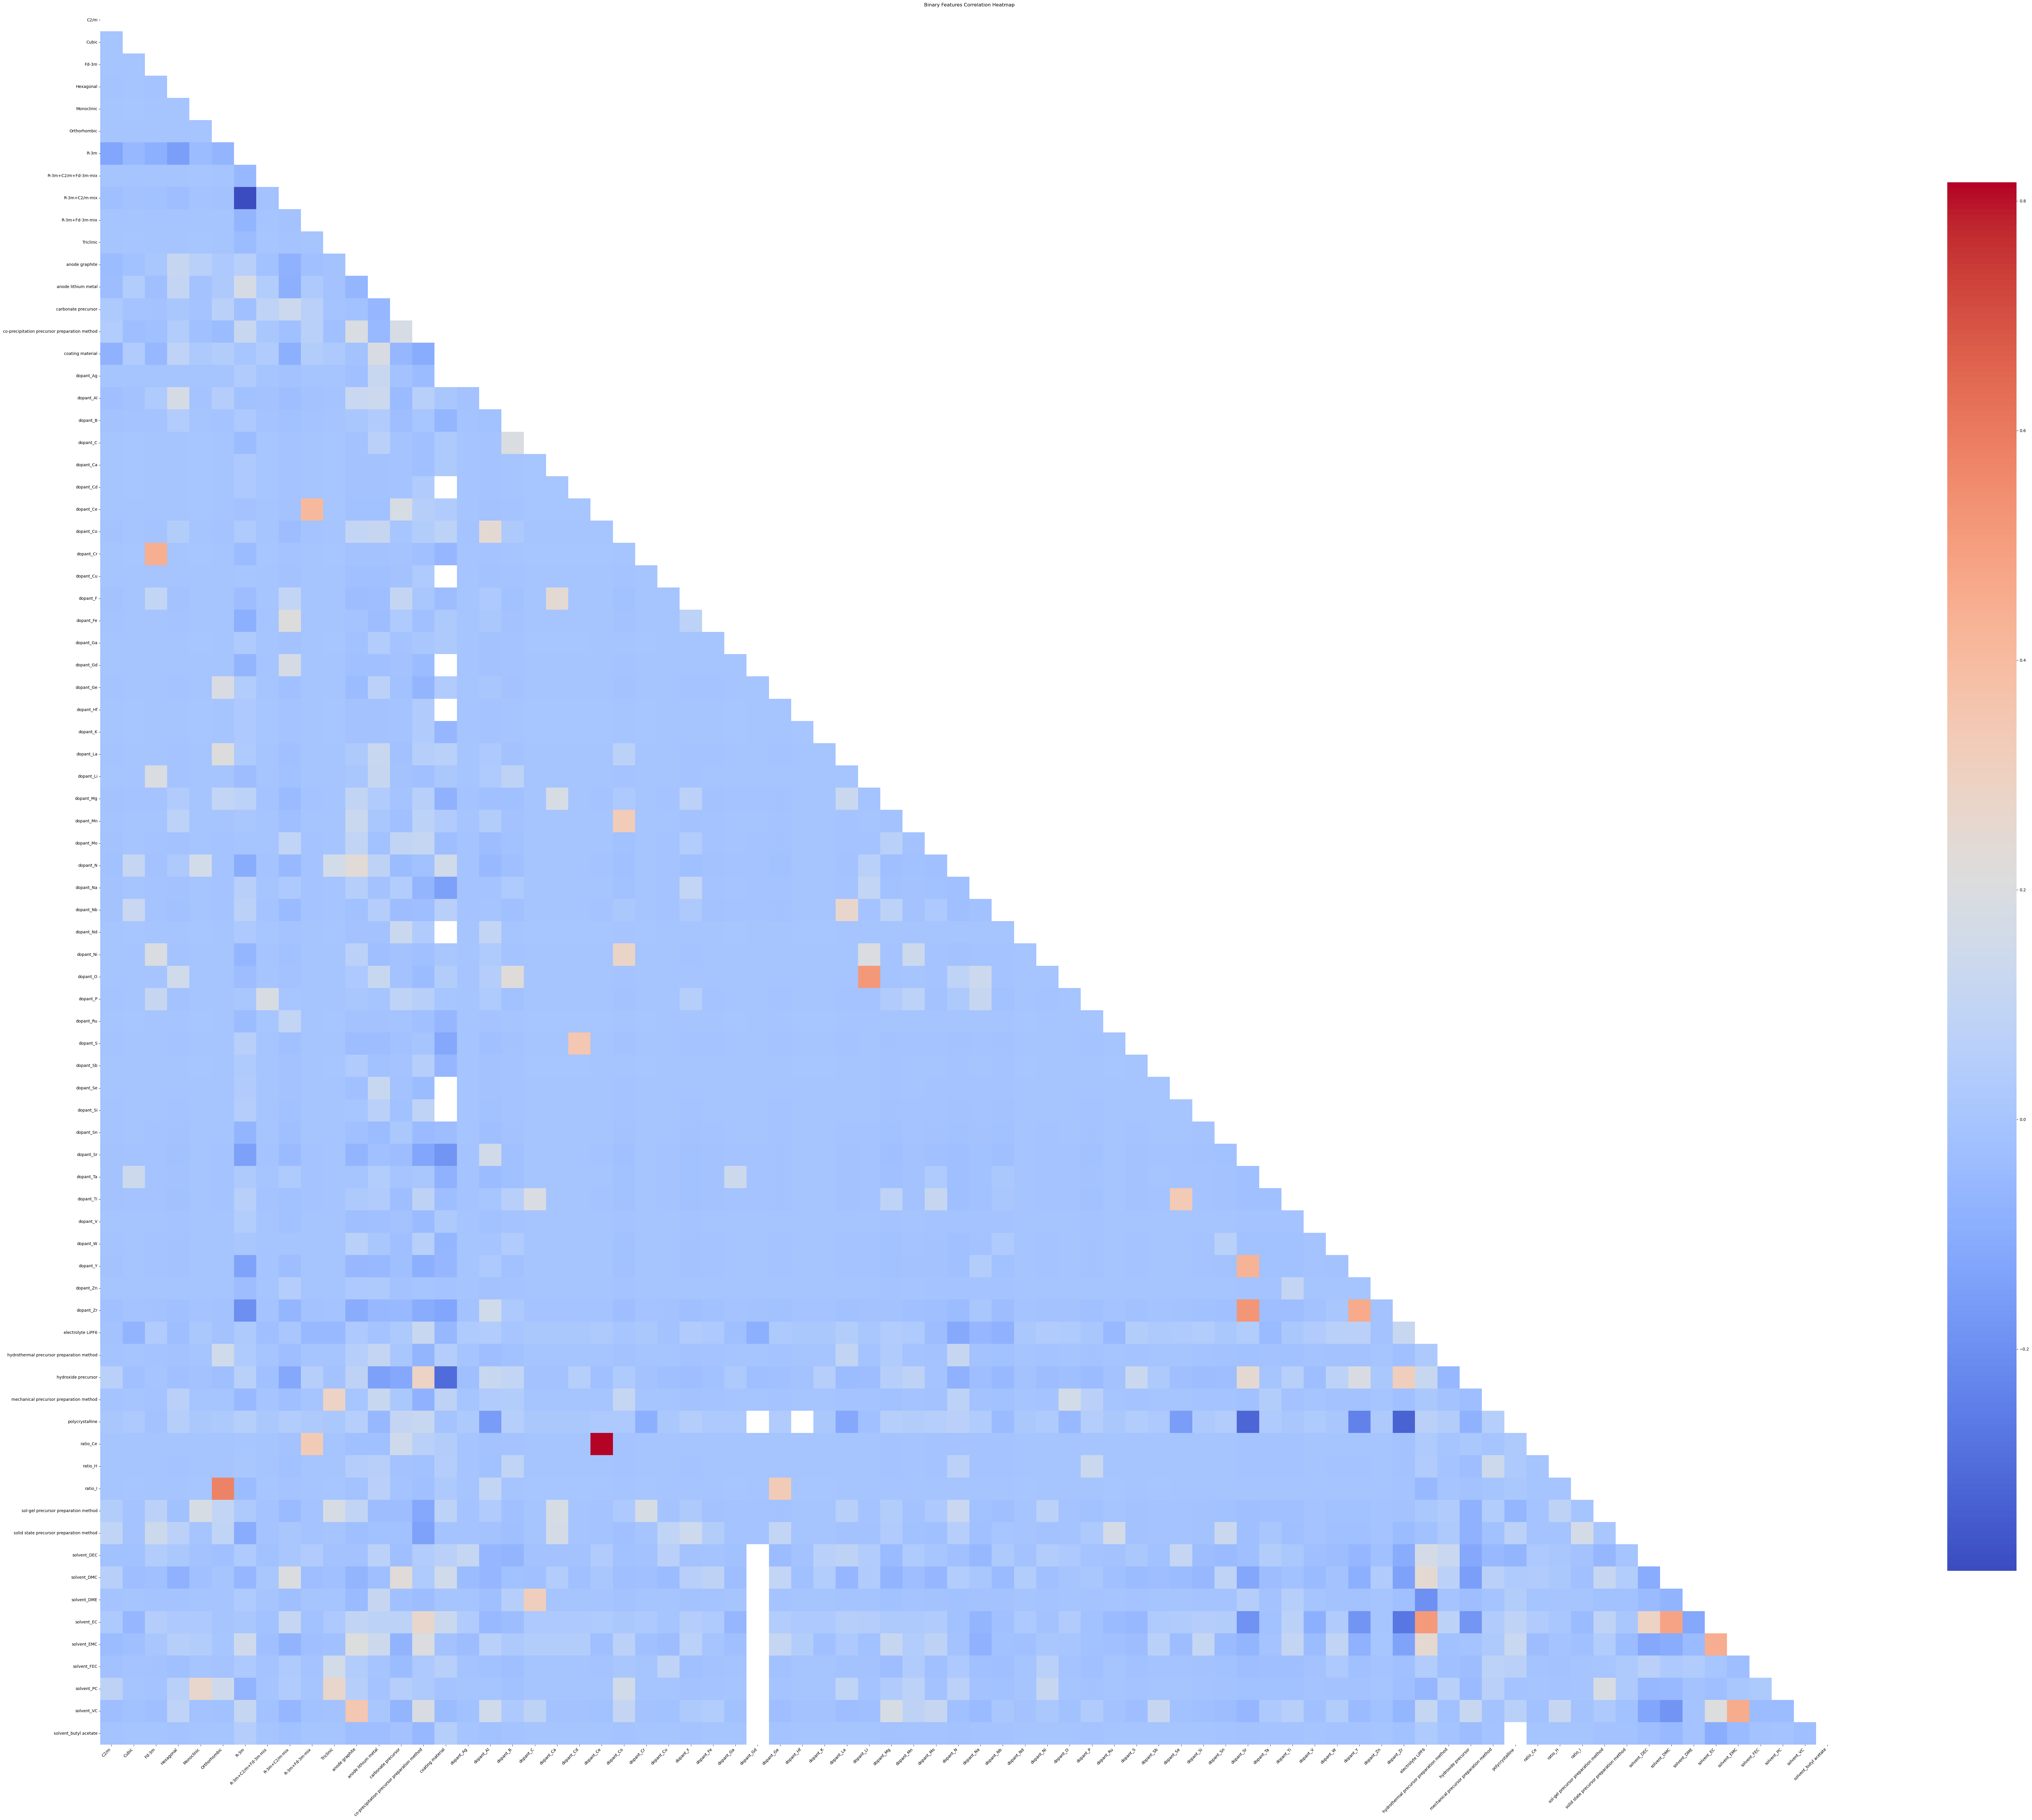

Saved correlation heatmap to: /home/karl/lithium_battery/data/Feature Engineering/Binary Features Correlation Heatmap.svg


In [12]:
plot_correlation_heatmap(df=df_lessnulls_binary, save_dir=FEATURE_ENG_DIR, plot_title="Binary Features Correlation Heatmap")

## 7. Value Distributions

Continuous Features

In [11]:
check_value_distributions(df=df_lessnulls_clip_cont, save_dir=FEATURE_ENG_DIR)

Saved 41 plot(s):
